![BGSE Summer School.](https://bse.eu/sites/default/files/pages/logo_bse_summer_school.png)

# Task Description for BSE Summer School Credit

This notebook contains the task decription for the Data Science Summer School Text Mining course by Ruben Durante and Hannes Mueller. You will use 3 million Spanish tweets to train your own emotion tracker for positive and negative emotion in tweets.

You should submit this notebook (to Hannes Mueller, hannes.mueller@bse.eu) completed with the following tasks:

1) build on the current notebook expanding the dictionary of positive emojis

2) build your own dictionary of negative emojis and generate a column in the tweets dataframe

3) pre-process the text column in the tweets dataframe (get rid of all emojis from your dictionaries in the pre-processing)

4) develop a supervised machine learning algorithm to detect positive and negative emotions using the text column

5) discuss the performance of your algorithm in terms of a) ROC-AUC and b) average precision

6) plot positive and negative emotions over time using the code provided below


# Solution by Mark Marner-Hausen and Lennart Struth


In [1]:
# Importing packages
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas() 
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Setting the path
# path = os.path.normpath("/content/drive/MyDrive/TextAnalysis")
# path = os.path.normpath("C:/Users/wmc464/Desktop/data")
# outpath = os.path.normpath("C:/Users/wmc464/Dropbox/textanalysis/data")
# path = os.path.normpath("/Users/lennartstruth/Dropbox/textanalysis/data/")
path = os.path.normpath("C:/Users/Mark/Google Drive/Colab Notebooks/TM/Task_for_credit")

## Steps 1 and 2: Building dicts of emojis (positive and negative) and label data

In the following code chunks we open the data and create labels for positive and negative emotions in the tweets by finding emojis that express positive/negative feelings in the texts of the tweets.

In [3]:
# Reading the data
tweets = pd.read_csv(os.path.join(path, 'esp_tweets_sample.csv'), index_col = 0)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 2 to 550009
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   user                          300000 non-null  int64  
 1   original_user                 229283 non-null  float64
 2   public_metrics.retweet_count  300000 non-null  int64  
 3   public_metrics.like_count     300000 non-null  int64  
 4   text                          300000 non-null  object 
 5   author.location               240223 non-null  object 
 6   author.description            235534 non-null  object 
 7   created_at                    300000 non-null  object 
 8   twlang                        300000 non-null  object 
 9   id                            229283 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 25.2+ MB


The following loop defines a regular expression to check for a set of positive/negative emojis and if it finds the pattern it saves the tweet in a list, makes a dummy that contains a 1 if the pattern was found and a 0 if there was no positive/negative emoji.

The dummy is then used further below to generate labels in the dataframe called "positive_emoji" and "negative_emoji", respectively.

In [4]:
# Finding emojis in the data frame to label the tweets as positve or negative
import re
pos_list = []
neg_list = []
pos_dummy = []
neg_dummy = []
for text in tweets.text:
    pos_regex = re.compile('👍|👍🏻|👍🏼|👍🏽|👍🏾👍🏿|👌|👌🏻|👌🏼|👌🏽|👌🏾|👌🏿|💪|💪🏻|💪🏼|💪🏽|💪🏾💪🏿|🙌|🙌🏻|🙌🏼|🙌🏽|🙌🏾|🙌🏿| \
                        👏|👏🏻|👏🏼|👏🏽|👏🏾|👏🏿|😀|😃|😄|😁|😆|🙂|😊|🥰|😍|🤩|☺️|🤗|😏|❤️‍🔥|🤣|😂| \
                        💋|💌|💘|💝|💖|💗|💓|💞|💕|💟|❣|❤|🧡|💛|💚|💙|💜|:\)|:D|😬|😌|😺| \
                        😸|😹|😻')
    neg_regex = re.compile('👎|👎🏻|👎🏼|👎🏽|👎🏾|👎🏿|👊|👊🏻|👊🏼|👊🏽|👊🏾|👊🏿|🤛|🤛🏻|🤛🏼|🤛🏽|🤛🏾|🤛🏿|🤜|🤜🏻|🤜🏼|🤜🏽|🤜🏾| \
                        🤜🏿|🖕|🖕🏻|🖕🏼|🖕🏽|🖕🏾|🖕🏿|🤐|😐|😑|😒|😔|🤕|🤢|🤮|😕|😟|🙁|☹️|🥺|😦|😧|😨| \
                        😰|😢|😭|😱|😖|😣|😞|😓|😩|😫|😤|😡|😠|🤬|💀|☠️|💩|😿|🙀|😾|💔|☹|☠| \
                        👿')
    pos_find = pos_regex.findall(text)
    neg_find = neg_regex.findall(text)
    if pos_find:
        pos_list.append(text)
        pos_dummy.append(1)
    else:
        pos_dummy.append(0)
    if neg_find:
        neg_list.append(text)
        neg_dummy.append(1)
    else:
        neg_dummy.append(0)

In [5]:
# Number of labels found
print(f"Number of positive labels: {len(pos_list)}")
print(f"Number of negative labels: {len(neg_list)}")

Number of positive labels: 6586
Number of negative labels: 1843


In [6]:
# Saving labels in the main data frame
tweets["positive_emoji"] = pos_dummy
tweets["negative_emoji"] = neg_dummy
tweets["count"] = 1

In [7]:
# Saving a copy of the data frame in a csv to be able to load for later steps
tweets.to_csv(os.path.join(path, 'labeled_tweets.csv'), index=False)

## Step 3) Preprocessing the data for predicting emotion from the text
In the next few code chunks we pre-process the text data following the approaches taken in the classes.

In [8]:
# Reading in the labeled tweets
df = pd.read_csv(os.path.join(path, 'labeled_tweets.csv'), index_col = 0)

# Keeping only uniquely labeled observations
df = df.loc[df["positive_emoji"] != df["negative_emoji"]].copy()

# Creating a class variable (1=positive, 0=negative) and drop all unneccessary features (keeping the text only for now)
df["class"] = df["positive_emoji"]
df = df[["class", "text"]].copy().reset_index(drop = True)

In [9]:
# Preprocessing the data set
import gensim
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

remove_punct = str.maketrans('','','!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“”’')
stop_words = list(set(stopwords.words('spanish')))
stemmer = SnowballStemmer('spanish')

# Writing a function that gets rid of all emojis in the tweets
def de_emojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

# Defining a function that prepares the text
def prep(txt):
    lower = txt.lower() # Transforming all letters to lower letters
    nopunc = lower.translate(remove_punct) # Removing punctuation
    noemoji = de_emojify(nopunc) # Removing emojis
    words = noemoji.split() # Splitting the str into tokens
    nostop = [w for w in words if w not in stop_words] # Removing stopwords from gensim and nltk stop word list
    stem_text = [stemmer.stem(w) for w in nostop] # Stemming to reduce words to their their common linguistic root
    return ' '.join(stem_text)

# Applying the functions to obtain a new column with the cleaned text
df['text_clean'] = df.text.apply(lambda row: prep(row))

## Step 4) Consider different supervised ml models to classify the tweets
In the following code chunks we build the training and testing data sets and consider a variety of models.

In [10]:
# Vectorizing the text using the tf-idf weights
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(
    min_df = 0.001,
    max_df = .975,
    max_features = None,
    ngram_range = (1,2),
    use_idf = True,
    lowercase = False
)
text_tok = vec.fit_transform(df['text_clean'])
text_tok = text_tok.todense()
words = vec.get_feature_names_out()

# Building feature matrix X and column y of labels
X = pd.DataFrame(text_tok, columns = words)
y = df['class'].copy()


# Splitting the data set into training and testing data
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
print(X.shape)

(8211, 1694)


---
Naive Forecaster

In [11]:
# Unconditional mean
def naive_forecaster(y_train):
  return np.mean(y_train)

---
Linear Regression

In [12]:
# Linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True)
reg.fit(X = X_train, y = y_train)

LinearRegression()

---
Logistic Regression

In [13]:
# Logit
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=10000)
logit.fit(X = X_train, y = y_train)

LogisticRegression(max_iter=10000)

---
Extra Trees Classifier

In [14]:
# Random forest using the ExtraTreesClassifier (henceforth "etc")
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
etc = ExtraTreesClassifier()

# Setting parameters
n_trees = 100
split = np.arange(0.01, 0.42, 0.1)
features = np.arange(5, 20, 4)
parameters = {'n_estimators': [n_trees],
              'class_weight': ['balanced_subsample'], 
              'min_samples_split': split,
              'max_features': features,
              'random_state': [42]}

# Grid search
etc_auc = GridSearchCV(etc, parameters, cv=5, verbose=1, n_jobs=3, 
                       return_train_score=True, refit=True, scoring='roc_auc')
                       
etc_pre = GridSearchCV(etc, parameters, cv=5, verbose=1, n_jobs=3, 
                       return_train_score=True, refit=True, scoring='average_precision')

# Fitting the model
etc_auc.fit(X_train, y_train)
etc_pre.fit(X_train, y_train)

print('Best set of parameters Roc-Auc:', etc_auc.best_estimator_)
print('Best set of parameters Avg-Precision:', etc_pre.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best set of parameters Roc-Auc: ExtraTreesClassifier(class_weight='balanced_subsample', max_features=13,
                     min_samples_split=0.41000000000000003, random_state=42)
Best set of parameters Avg-Precision: ExtraTreesClassifier(class_weight='balanced_subsample', max_features=13,
                     min_samples_split=0.41000000000000003, random_state=42)


---
Gradient Boosting Classifier

In [15]:
# Gradient Boost (henceforth "gbc")
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

# Setting parameters
parameters = {'n_estimators': [100], 
              'learning_rate': [0.1],
              'min_samples_split': np.arange(0.01, 0.18, 0.08),
              'max_depth': np.arange(26, 50, 6),
              'random_state': [42]}

# Grid search
gbc_auc = GridSearchCV(gbc, parameters, cv=5, verbose=1, n_jobs=3, 
                       return_train_score=True, refit=True, scoring='roc_auc')
gbc_pre = GridSearchCV(gbc, parameters, cv=5, verbose=1, n_jobs=3, 
                       return_train_score=True, refit=True, scoring='average_precision')

# Fitting the model
gbc_auc.fit(X_train, y_train)
gbc_pre.fit(X_train, y_train)

print('Best set of parameters Roc-Auc:', gbc_auc.best_estimator_)
print('Best set of parameters Avg-Precision:', gbc_pre.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best set of parameters Roc-Auc: GradientBoostingClassifier(max_depth=38, min_samples_split=0.01,
                           random_state=42)
Best set of parameters Avg-Precision: GradientBoostingClassifier(max_depth=44, min_samples_split=0.01,
                           random_state=42)


---
Ada Boost Classifier

In [16]:
# Ada boost (henceforth "abc")
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

# Setting parameters
parameters = {'n_estimators': [100], 
              'learning_rate': [0.1],
              'random_state': [42]}

# Grid search
abc_auc = GridSearchCV(abc, parameters, cv=5, verbose=1, n_jobs=3, return_train_score=True, refit=True, scoring='roc_auc')
abc_pre = GridSearchCV(abc, parameters, cv=5, verbose=1, n_jobs=3, return_train_score=True, refit=True, scoring='average_precision')

# Fitting the model
abc_auc.fit(X_train, y_train)
abc_pre.fit(X_train, y_train)

print('Best set of parameters Roc-Auc:', abc_auc.best_estimator_)
print('Best set of parameters Avg-Precision:', abc_pre.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best set of parameters Roc-Auc: AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
Best set of parameters Avg-Precision: AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)


In [17]:
# Creating a data frame that stores predicted values to compare prediction results in the next section
forecast = pd.DataFrame(y_test)
forecast["naive"] = naive_forecaster(y_train)
forecast["reg"] = reg.predict(X_test)
forecast["logit"] = logit.predict_proba(X_test)[:,1]
forecast['etc_auc'] = etc_auc.predict_proba(X_test)[:, 1]
forecast['etc_pre'] = etc_pre.predict_proba(X_test)[:, 1]
forecast['gbc_auc'] = gbc_auc.predict_proba(X_test)[:, 1]
forecast['gbc_pre'] = gbc_pre.predict_proba(X_test)[:, 1]
forecast['abc_auc'] = abc_auc.predict_proba(X_test)[:, 1]
forecast['abc_pre'] = abc_pre.predict_proba(X_test)[:, 1]


## Step 5) Evaluating the models' performance in terms of ROC-AUC and average precision
In this step, we compute the ROC-AUC scores, plot the corresponding ROC curves and compute the average precision of the different models. A brief interpretation of the results can be found below the graphs.

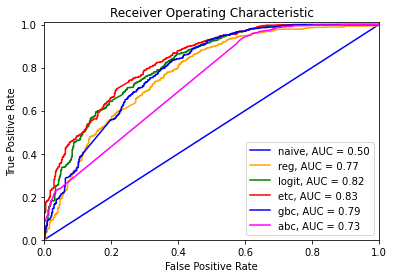

In [18]:
# Evaluating the model performance by their ROC curve and the ROC-AUC score
from sklearn import metrics
xax_naive, yax_naive, threshold_naive = metrics.roc_curve(y_test, forecast['naive'])
roc_auc_naive = metrics.roc_auc_score(y_test, forecast['naive'])

xax_reg, yax_reg, threshold_reg = metrics.roc_curve(y_test, forecast['reg'])
roc_auc_reg = metrics.roc_auc_score(y_test, forecast['reg'])

xax_logit, yax_logit, threshold_logit = metrics.roc_curve(y_test, forecast['logit'])
roc_auc_logit = metrics.roc_auc_score(y_test, forecast['logit'])

xax_etc_auc, yax_etc_auc, threshold_etc_auc = metrics.roc_curve(y_test, forecast['etc_auc'])
roc_auc_etc = metrics.roc_auc_score(y_test, forecast['etc_auc'])

xax_gbc_auc, yax_gbc_auc, threshold_gbc_auc = metrics.roc_curve(y_test, forecast['gbc_auc'])
roc_auc_gbc = metrics.roc_auc_score(y_test, forecast['gbc_auc'])

xax_abc_auc, yax_abc_auc, threshold_abc_auc = metrics.roc_curve(y_test, forecast['abc_auc'])
roc_auc_abc = metrics.roc_auc_score(y_test, forecast['abc_auc'])

# Plotting the ROC curves and showing the ROC-AUC scores
plt.title('Receiver Operating Characteristic')
plt.plot(xax_naive, yax_naive, 'blue', label = 'naive, AUC = %0.2f' % roc_auc_naive)
plt.plot(xax_reg, yax_reg, 'orange', label = 'reg, AUC = %0.2f' % roc_auc_reg)
plt.plot(xax_logit, yax_logit, 'green', label = 'logit, AUC = %0.2f' % roc_auc_logit)
plt.plot(xax_etc_auc, yax_etc_auc, 'red', label = 'etc, AUC = %0.2f' % roc_auc_etc)
plt.plot(xax_gbc_auc, yax_gbc_auc, 'blue', label = 'gbc, AUC = %0.2f' % roc_auc_gbc)
plt.plot(xax_abc_auc, yax_abc_auc, 'magenta', label = 'abc, AUC = %0.2f' % roc_auc_abc)
plt.rcParams["figure.figsize"] = (20,8)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

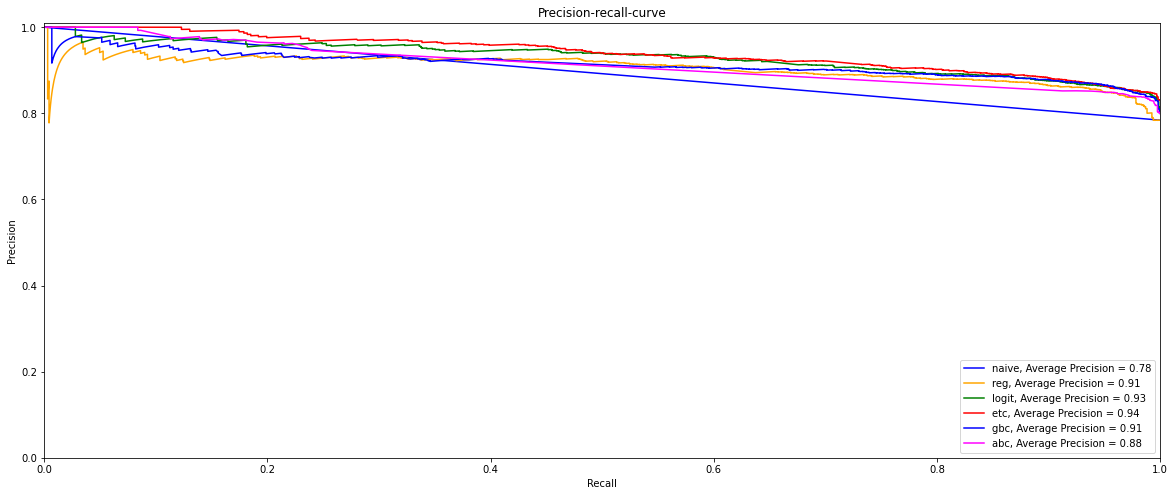

In [19]:
# Evaluating the model performance by their average precision
prec_naive, recall_naive, threshold_naive = metrics.precision_recall_curve(y_test, forecast['naive'])
avg_prec_naive = metrics.average_precision_score(y_test, forecast['naive'])

prec_reg, recall_reg, threshold_reg = metrics.precision_recall_curve(y_test, forecast['reg'])
avg_prec_reg = metrics.average_precision_score(y_test, forecast['reg'])

prec_logit, recall_logit, threshold_logit = metrics.precision_recall_curve(y_test, forecast['logit'])
avg_prec_logit = metrics.average_precision_score(y_test, forecast['logit'])

prec_etc, recall_etc, threshold_etc = metrics.precision_recall_curve(y_test, forecast['etc_pre'])
avg_prec_etc = metrics.average_precision_score(y_test, forecast['etc_pre'])

prec_gbc, recall_gbc, threshold_gbc = metrics.precision_recall_curve(y_test, forecast['gbc_pre'])
avg_prec_gbc = metrics.average_precision_score(y_test, forecast['gbc_pre'])

prec_abc, recall_abc, threshold_abc = metrics.precision_recall_curve(y_test, forecast['abc_pre'])
avg_prec_abc = metrics.average_precision_score(y_test, forecast['abc_pre'])

# Plotting the Precision-recall curves and showing the average precision scores
plt.title('Precision-recall-curve')
plt.plot(recall_naive, prec_naive, 'blue', label = 'naive, Average Precision = %0.2f' % avg_prec_naive)
plt.plot(recall_reg, prec_reg, 'orange', label = 'reg, Average Precision = %0.2f' % avg_prec_reg)
plt.plot(recall_logit, prec_logit, 'green', label = 'logit, Average Precision = %0.2f' % avg_prec_logit)
plt.plot(recall_etc, prec_etc, 'red', label = 'etc, Average Precision = %0.2f' % avg_prec_etc)
plt.plot(recall_gbc, prec_gbc, 'blue', label = 'gbc, Average Precision = %0.2f' % avg_prec_gbc)
plt.plot(recall_abc, prec_abc, 'magenta', label = 'abc, Average Precision = %0.2f' % avg_prec_abc)
plt.rcParams["figure.figsize"] = (20,8)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Comment on the performance of the models in terms of ROC-AUC score and average precision

Independent of whether the model is tuned with the objective of maximizing the ROC-AUC score or the average precision, the ExtraTreesClassifier() performs best. 
In the following, a Confusion Matrix is presented for both objectives. Note, however, that the predicted labels and not the probabilities discussed so far are needed for this purpose. The confusion matrices are calculated based on the default threshold 0.5:

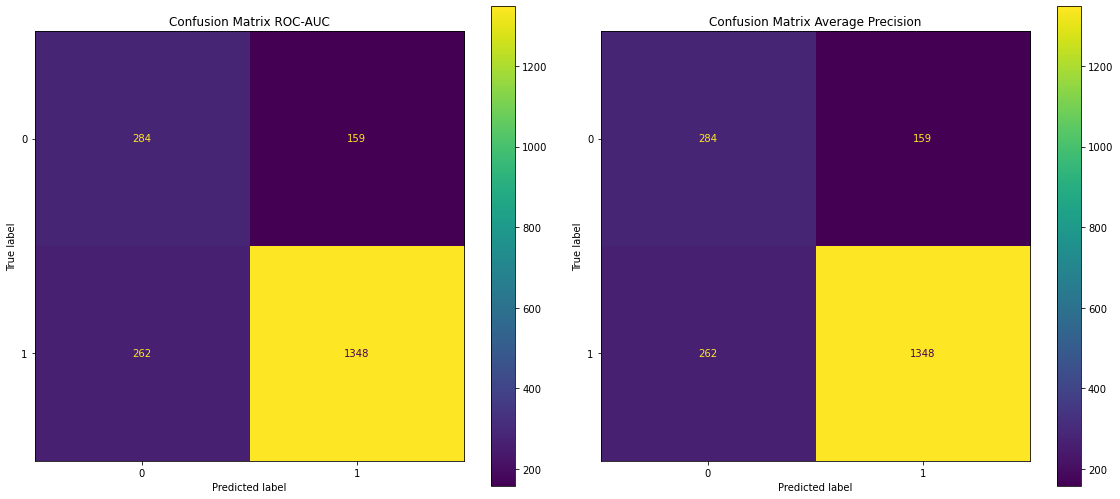

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting the emotion using the etc model
y_pred_auc = etc_auc.predict(X_test)  # default threshold is 0.5
y_pred_pre = etc_pre.predict(X_test)  # default threshold is 0.5

# Computing the confusion matrices for both scoring rules
cm_auc = confusion_matrix(y_test, y_pred_auc)
cm_pre = confusion_matrix(y_test, y_pred_pre)

disp_auc = ConfusionMatrixDisplay(confusion_matrix = cm_auc)
disp_pre = ConfusionMatrixDisplay(confusion_matrix = cm_pre)

# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
ax1.title.set_text("Confusion Matrix ROC-AUC")
ax2.title.set_text("Confusion Matrix Average Precision")
disp_auc.plot(ax = ax1)
disp_pre.plot(ax = ax2)
fig.tight_layout()
plt.show()

Reminder: The number of False Positives is shown on the upper right, the number of False Negatives on the lower left.
Precision = TP / (TP + FP).
Recall = TP / (TP + FN).

Surprisingly, both matrices are very similar.
Suppose we are particularly concerned that a tweet that is classified as positive is indeed positive. We could consider a threshold larger than 0.5, which is done below using the example model with objective average precision. Note, however, that the Precision-Recall Curve is steep, thus, reducing the number of False Positives will lead to strong adverse effects regarding True Positive and False Negative.

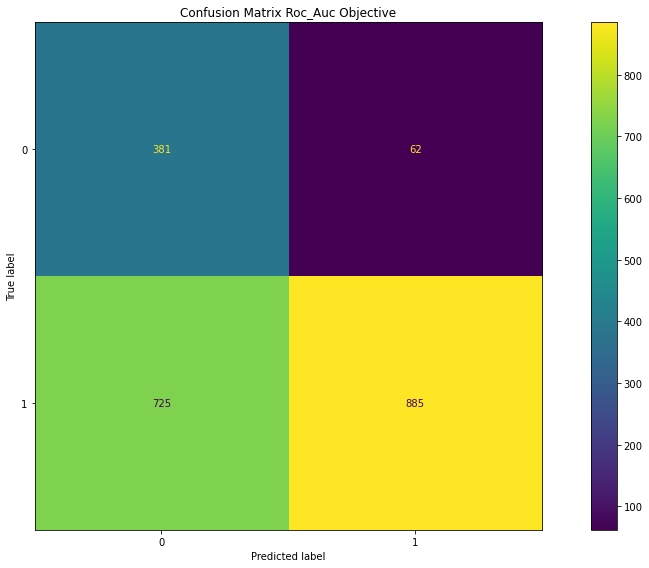

In [21]:
y_pred = (etc_pre.predict_proba(X_test)[:,1] >= 0.6).astype(bool) # set threshold as 0.6

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

fig, (ax1) = plt.subplots(1, figsize=(14,8))
ax1.title.set_text("Confusion Matrix Roc_Auc Objective")
disp.plot(ax = ax1)
fig.tight_layout()
plt.show()


## Step 6) Plot positive and negative emotions over time
In this step, we use the machine learning methods from before to predict the emotions of the so far unlabeled tweets and plot the development of emotions over time.

First, we load again the full data set of all tweets. Second, we split the data set into the tweets that we were able to label via the emojis (the subset of tweets we were using for the choice of the supervised ml method) and the tweets that remain unlabeled.

In [22]:
# Reading in the tweets (of which a fraction is labeled) and cleaning the text again
tweets = pd.read_csv(os.path.join(path, 'labeled_tweets.csv'), index_col = 0)
tweets['text_clean'] = tweets.text.apply(lambda row: prep(row))

# Splitting the data set into uniquely labeled and 'unlabeled' tweets
tweets_labeled = tweets.loc[tweets["positive_emoji"] != tweets["negative_emoji"]].copy() # Tweets that are used for training the model (labeled by the emojis)
tweets_unlabeled = tweets.loc[tweets["positive_emoji"] == tweets["negative_emoji"]].copy() # Tweets for which the emotion will be predicted

# Dropping all unnecessary features
tweets_labeled["positive"] = tweets_labeled["positive_emoji"]
tweets_labeled = tweets_labeled[["positive", "text_clean", "created_at"]]
tweets_unlabeled = tweets_unlabeled[["text_clean", "created_at"]]

Next, we build the feature matrices using the tf-idf weighting for both subsets separately. Then, we train the etc model on the first set of tweets (those that were labeled using the emojis), and use the trained model to predict the emotion of the remaining (so far unlabeled) tweets. Finally, we concatenate both data sets again.

In [23]:
# Vectorizing the labeled text using the tf-idf weights
text_tok_labeled = vec.fit_transform(tweets_labeled['text_clean'])
text_tok_labeled = text_tok_labeled.todense()
words_labeled = vec.get_feature_names_out()

# Vectorizing the unlabeled text using the tf-idf weights
text_tok_unlabeled = vec.fit_transform(tweets_unlabeled['text_clean'])
text_tok_unlabeled = text_tok_unlabeled.todense()
words_unlabeled = vec.get_feature_names_out()

# Keeping only the words that appear in both labeled and unlabeled data set
feature_list = list(set(words_labeled.tolist()) & set(words_unlabeled.tolist()))

# Building X and y for training
X_labeled = pd.DataFrame(text_tok_labeled, columns = words_labeled)[feature_list]
y_labeled = tweets_labeled["positive"]

# Building feature matrix X for predicting emotion
X_unlabeled = pd.DataFrame(text_tok_unlabeled, columns = words_unlabeled)[feature_list]

# Training the etc on the labeled data set
etc_auc.fit(X_labeled, y_labeled)

# Predicting emotion for unlabeled tweets
tweets_unlabeled["positive"] = etc_auc.predict(X_unlabeled)

# Keeping only the classifier positive and the date in the labeled data set and adding count variable
tweets_labeled = tweets_labeled[["positive", "created_at"]]
tweets_labeled['count'] = 1

# Keeping only the class positive and the date in the labeled data set and adding count variable
tweets_unlabeled = tweets_unlabeled[["positive", "created_at"]]
tweets_unlabeled['count'] = 1

# Appending the data sets
tweets = pd.concat([tweets_labeled, tweets_unlabeled]).copy()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Next, we plot the number of tweets per hour as well as the fraction of positive tweets per hour. Additionally, we plot the absolute number of negative tweets per hour. A brief description of the results can be found below.

In [24]:
# Getting the date and hour from the meta data
tweets['publish_date'] = pd.to_datetime(tweets['created_at'])
tweets["date"] = tweets['publish_date'].dt.date
tweets["hour"] = tweets['publish_date'].dt.hour

# Creating a data frame that stores the number and shares of positive and negative tweets per hour
df_plot = pd.DataFrame(tweets.groupby([tweets['date'], tweets['hour']])['positive'].sum())
df_plot["total"] = pd.DataFrame(tweets.groupby([tweets['date'], tweets['hour']])['count'].sum())
df_plot["negative"] = df_plot["total"] - df_plot["positive"]
df_plot["pos_share"] = df_plot['positive']/df_plot["total"]
df_plot["neg_share"] = 1 - df_plot['pos_share']

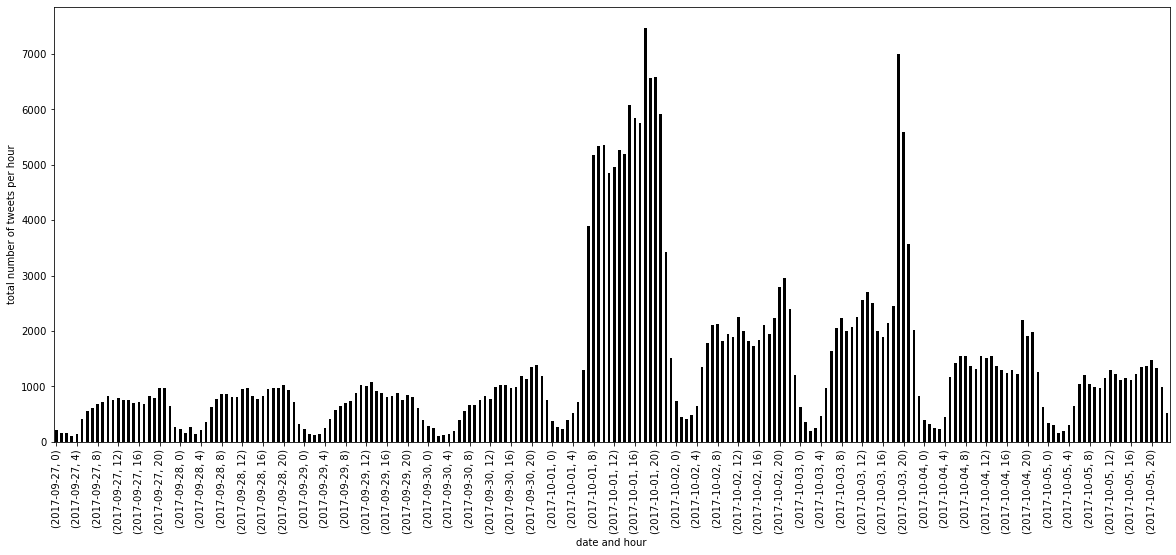

In [25]:
# Plotting the number of total tweets over time
plt.rcParams["figure.figsize"] = (20,8)
df_plot['total'].plot(kind='bar', color='black')
plt.xlabel("date and hour")
plt.ylabel("total number of tweets per hour")
plt.locator_params(axis='x', nbins=61)
plt.show()

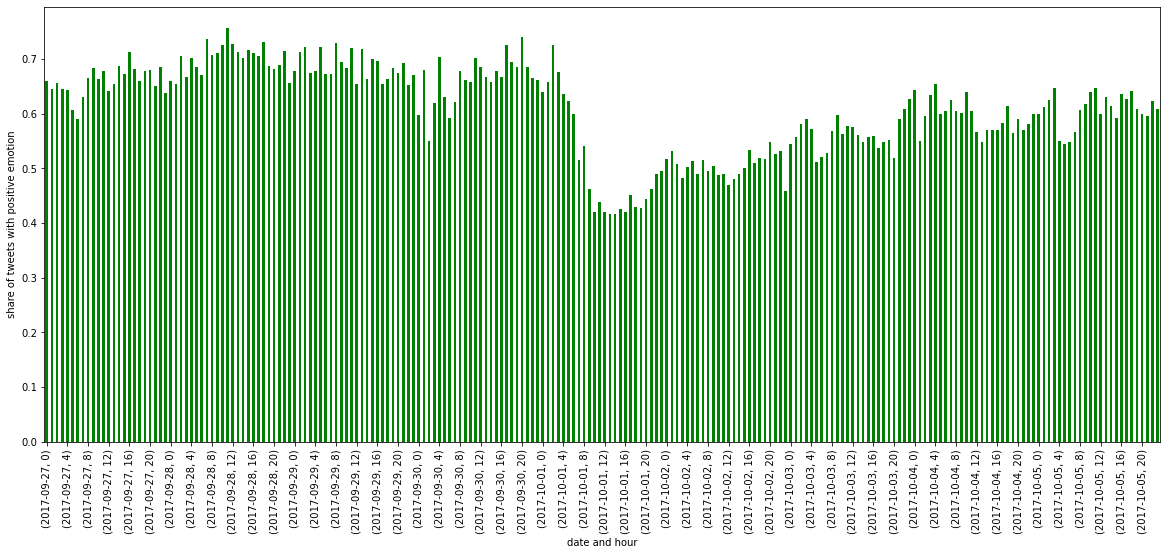

In [26]:
# Plotting the share of positive tweets per hour
plt.rcParams["figure.figsize"] = (20,8)
df_plot["pos_share"].plot(kind='bar', color='green')
plt.xlabel("date and hour")
plt.ylabel("share of tweets with positive emotion")
plt.locator_params(axis='x', nbins=61)            
plt.show()

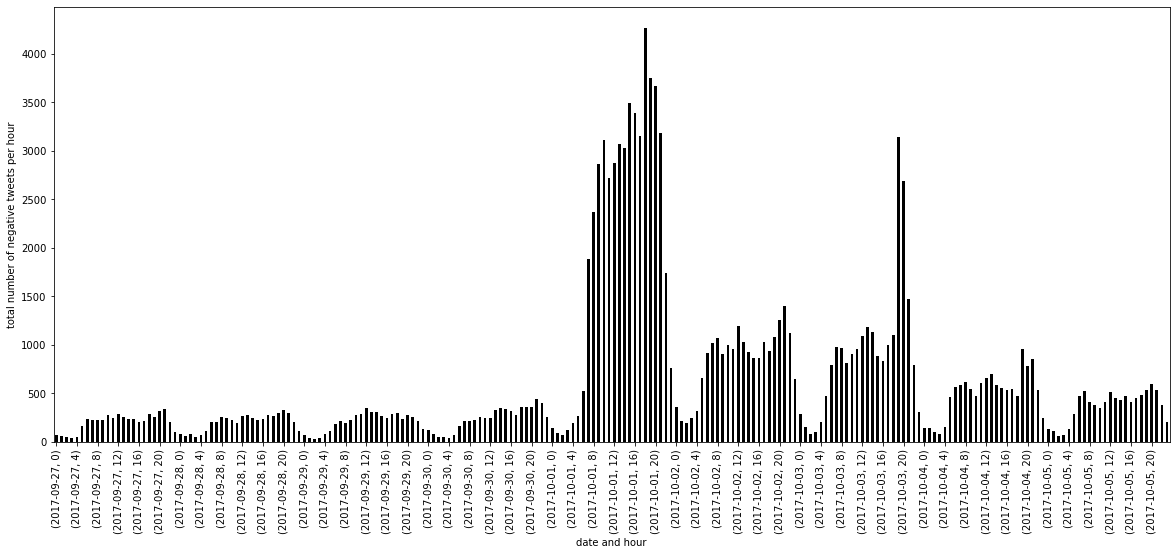

In [27]:
# Plotting the number of negative tweets over time
plt.rcParams["figure.figsize"] = (20,8)
df_plot['negative'].plot(kind='bar', color='black')
plt.xlabel("date and hour")
plt.ylabel("total number of negative tweets per hour")
plt.locator_params(axis='x', nbins=61)
plt.show()

Brief review on the results: First, we can clearly see a surge on the absolute number of tweets on October 01, 2017, the day at which the Spanish police attempted to stop a vote in Catalunya using violence, as well as on the following October 03, 2017. Second, we observe a strong decrease in the fraction of tweets that are associated with positive emotions.
Additionally, although this is expected from the first two plots, we show the development of the absolute number of negative tweets over the corresponding time period. Clearly, we observe a strong increase of negative tweets on the first of October, as well as on the evening of October 03, 2017.